In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization, LeakyReLU, Flatten, Activation, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train/'
test_dir = '../input/intel-image-classification/seg_test/seg_test/'

In [3]:
data_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=32,
    class_mode = 'categorical'
)

test_gen = data_gen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:
def build_model():
    
    model = Sequential()
    
    
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(150,150,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    
    return model
    

In [5]:
es = EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000001)

In [6]:
optimizer = Adam(learning_rate=0.5e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [7]:
model = build_model()
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [8]:
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 256, 
    validation_data  = test_gen,
    validation_steps = 256,
    epochs = 30, 
    verbose = 1,
    callbacks = [es, learning_rate_reduction]
)

Epoch 1/30
256/256 [==============================] - 136s 530ms/step - loss: 0.5305 - accuracy: 0.8338 - val_loss: 0.2926 - val_accuracy: 0.8796
Epoch 2/30
256/256 [==============================] - 121s 474ms/step - loss: 0.3236 - accuracy: 0.8703 - val_loss: 0.2129 - val_accuracy: 0.8923
Epoch 3/30
256/256 [==============================] - 112s 437ms/step - loss: 0.2905 - accuracy: 0.8832 - val_loss: 0.2037 - val_accuracy: 0.9065
Epoch 4/30
256/256 [==============================] - 113s 441ms/step - loss: 0.2826 - accuracy: 0.8878 - val_loss: 0.3408 - val_accuracy: 0.9037
Epoch 5/30
256/256 [==============================] - 113s 441ms/step - loss: 0.2607 - accuracy: 0.8992 - val_loss: 0.2835 - val_accuracy: 0.9217
Epoch 6/30
256/256 [==============================] - 113s 443ms/step - loss: 0.2493 - accuracy: 0.9031 - val_loss: 0.2291 - val_accuracy: 0.9156
Epoch 7/30
256/256 [==============================] - 112s 437ms/step - loss: 0.2345 - accuracy: 0.9100 - val_loss: 0.2194 -

In [9]:
model.save("model_95.h5")

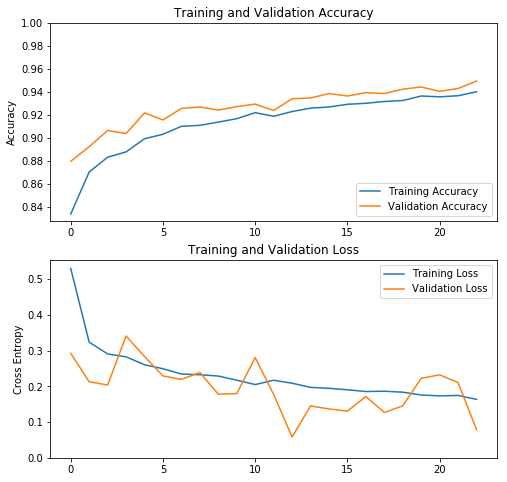

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [11]:
import os
import cv2

def get_images(directory):
    Images = []
    Labels = [] 
    label = 0
    
    for labels in os.listdir(directory): 
        if labels == 'glacier':
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            image = cv2.resize(image,(150,150))
            Images.append(image)
            Labels.append(label)
    
    return Images,Labels

In [12]:
from keras.utils import to_categorical

test_images,test_labels = get_images('../input/intel-image-classification/seg_test/seg_test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = to_categorical(test_labels)

In [13]:
model.evaluate(test_images, test_labels)

3000/3000 [==============================] - 5s 2ms/step


[0.28853836644254627, 0.8929443955421448]

In [14]:
def get_images_for_prediction(directory):
    Images = []
    
    for image_file in os.listdir(directory):
        image = cv2.imread(directory+r'/'+image_file)
        image = cv2.resize(image,(150,150))
        Images.append(image)
    
    return Images

In [15]:
prediction_images = get_images_for_prediction('../input/intel-image-classification/seg_pred/seg_pred/')

In [16]:
prediction_images = np.array(prediction_images)
prediction_images.shape

(7301, 150, 150, 3)

In [17]:
res = model.predict(prediction_images)

In [18]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

labels = ['buildings','forest','glacier','mountain','sea','street']

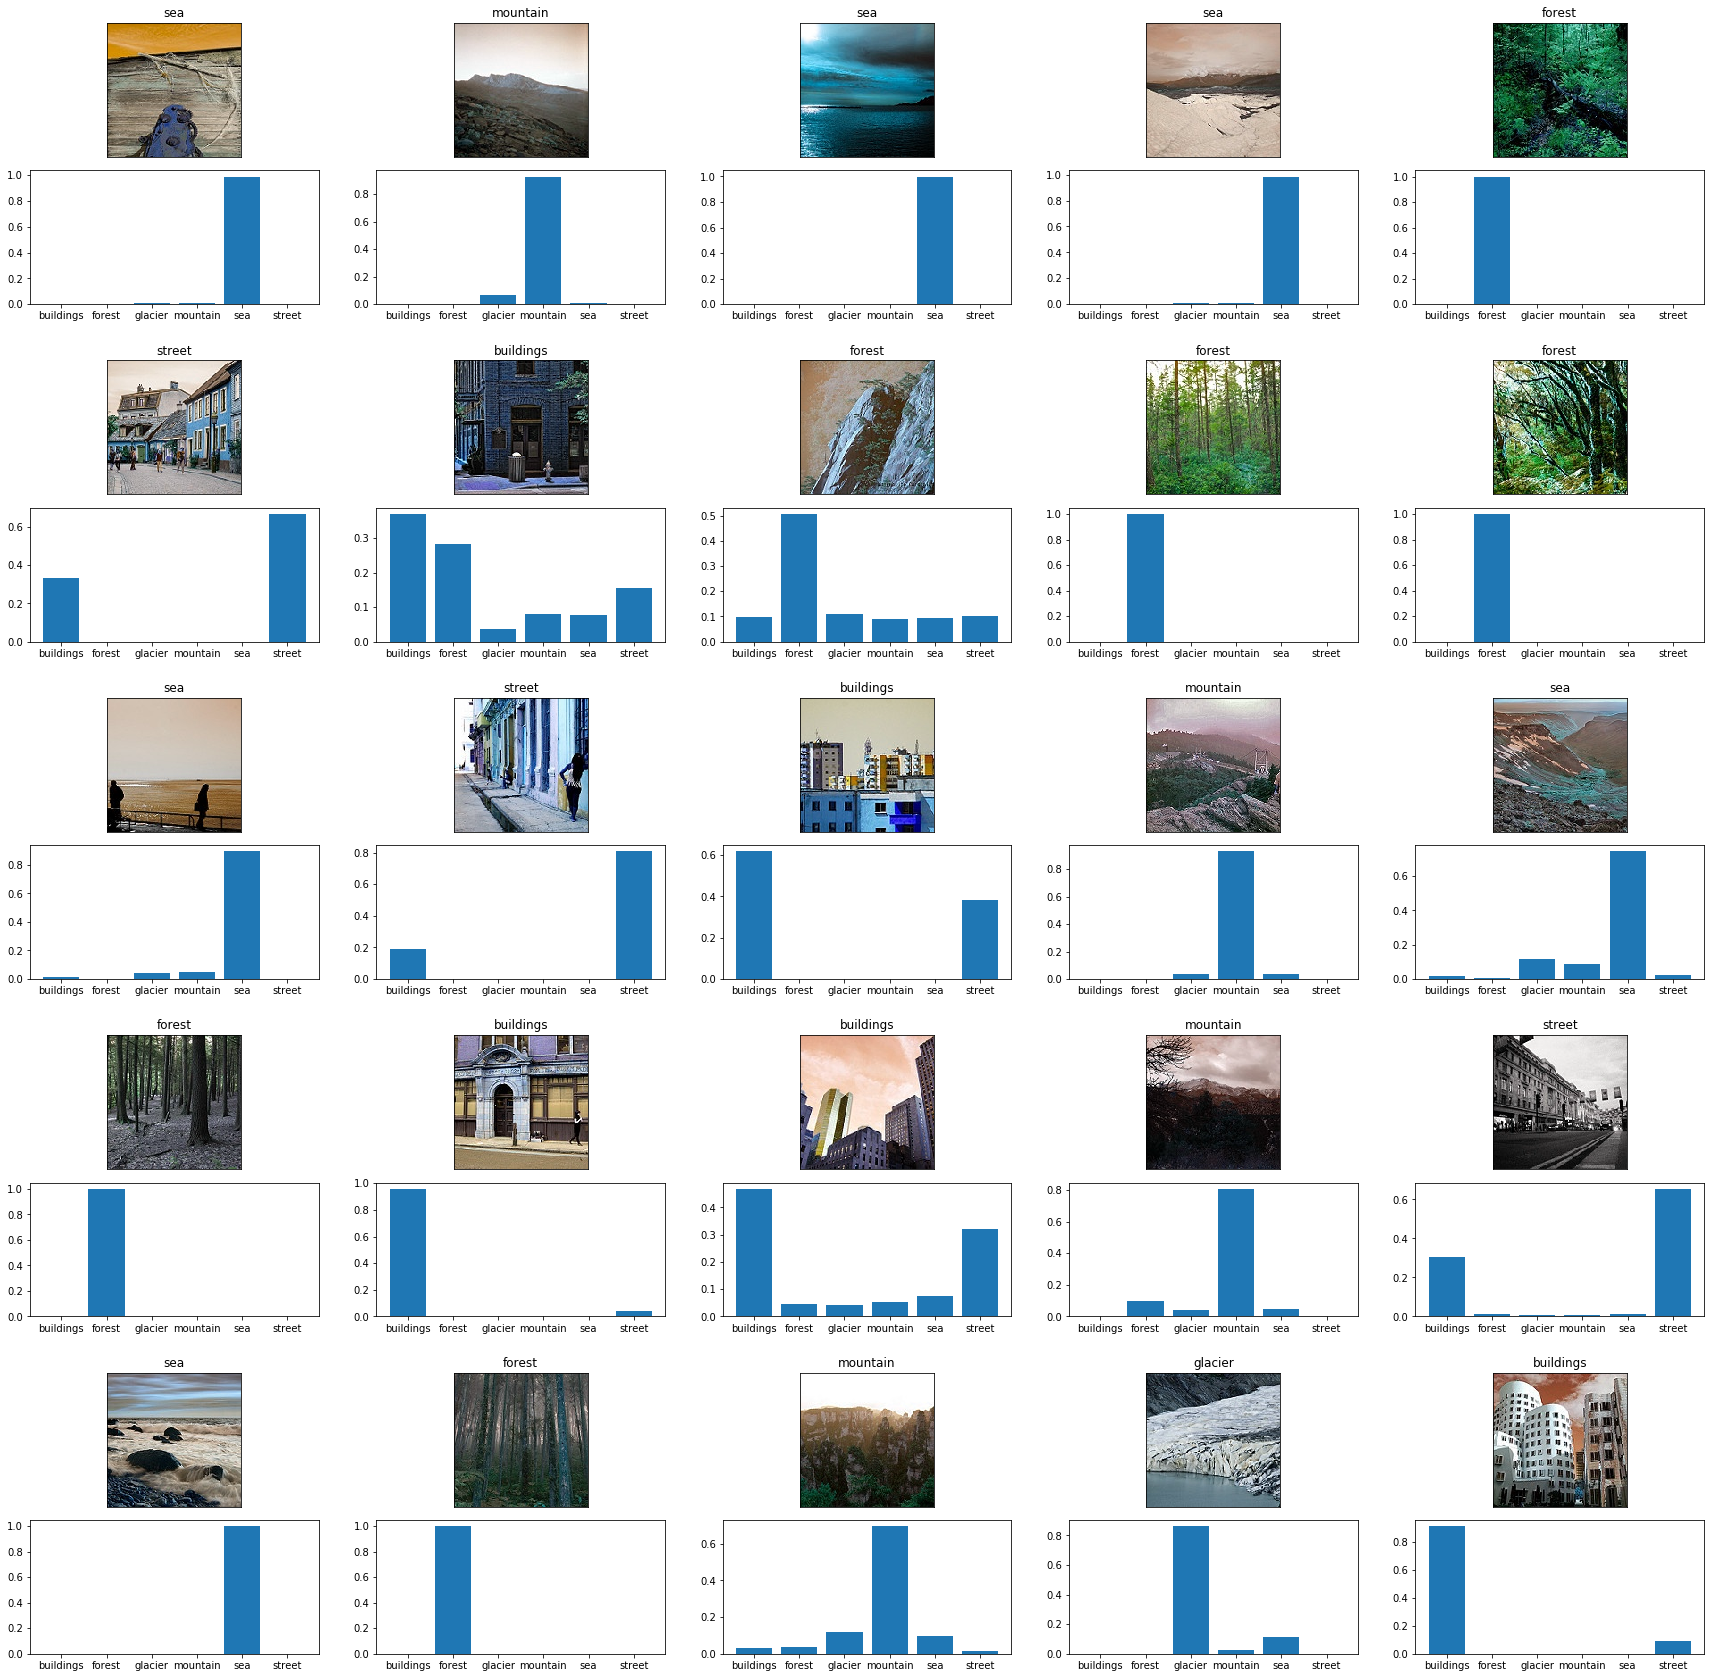

In [19]:
import matplotlib.gridspec as gridspec
from random import randint

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(res))
    pred_image = np.array([prediction_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar(labels,pred_prob)
            fig.add_subplot(ax)


fig.show()